<a href="https://colab.research.google.com/github/FedericoMelograna/CTBN_PhaseDistribution/blob/master/GenNet_CoActivation/COMPLETE__GenNet_gene_wise_epistasis%2C_coactivation_binomial_gtest_significance_assessment_DIFFERENTIAL_residuals_crossgene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proof of Concept GenNet


1. Copy to playground
2. Press Runtime > Run all or ctrl + F9

## Initialization

In [1]:
pip install numpy==1.19.3

     |████████████████████████████████| 14.9 MB 5.5 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.19.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
pip install tensorflow==2.4.0

     |████████████████████████████████| 394.7 MB 15 kB/s 
     |████████████████████████████████| 132 kB 35.6 MB/s 
     |████████████████████████████████| 3.8 MB 33.4 MB/s 
     |████████████████████████████████| 462 kB 37.3 MB/s 
     |████████████████████████████████| 2.9 MB 31.3 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68727 sha256=fc35b9eb90c98a34ea8a6ed89eab0a812904bb43d9f1888c85ab57f0d1cd2d8f
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.44.0
    Uninstalling grpcio-1.44.0:
      Successfully uninstalled grpcio-1.44.0
  Attempting uninstall: absl-py
    Found existing installation: ab

In [3]:
#@title Importing python modules { display-mode: "form" }

import tensorflow as tf
import os
from scipy.sparse import coo_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras as K
import sklearn.metrics as skm
import scipy
import sys

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as Kb
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import InputSpec
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.util.tf_export import tf_export
from tensorflow.python.framework.ops import disable_eager_execution

#disable_eager_execution()


In [4]:
#@title Locally-Directed1D layer
"""Locally-Directed1D layer.
"""



@tf_export('keras.layers.LocallyDirected1D')
class LocallyDirected1D(Layer):
    """Locally-Directed1D layer for 1D inputs.

  The `LocallyDirected1D` layer works similarly to
  the `Conv1D` layer, except that weights are unshared,
  that is, a different set of filters is applied at each different patch
  of the input.

  Example:
  ```python
      # apply a unshared weight convolution 1d of length 3 to a sequence with
      # 10 timesteps, with 64 output filters
      model = Sequential()
      model.add(LocallyDirected1D(64, 3, input_shape=(10, 32)))
      # now model.output_shape == (None, 8, 64)
      # add a new conv1d on top
      model.add(LocallyDirected1D(32, 3))
      # now model.output_shape == (None, 6, 32)
  ```

  Arguments:
      mask: sparse matrix with shape (input, output) connectivity matrix,
            True defines connection between (in_i, out_j), should be sparse (False,0) >> True
            should be scipy sparese matrix in COO Format!
      filters: Integer, the dimensionality of the output space
          (i.e. the number of output filters in the convolution).
      kernel_size: An integer or tuple/list of a single integer,
          specifying the length of the 1D convolution window.
      strides: An integer or tuple/list of a single integer,
          specifying the stride length of the convolution.
          Specifying any stride value != 1 is incompatible with specifying
          any `dilation_rate` value != 1.
      padding: Currently only supports `"valid"` (case-insensitive).
          `"same"` may be supported in the future.
      data_format: A string,
          one of `channels_last` (default) or `channels_first`.
          The ordering of the dimensions in the inputs.
          `channels_last` corresponds to inputs with shape
          `(batch, length, channels)` while `channels_first`
          corresponds to inputs with shape
          `(batch, channels, length)`.
          It defaults to the `image_data_format` value found in your
          Keras config file at `~/.keras/keras.json`.
          If you never set it, then it will be "channels_last".
      activation: Activation function to use.
          If you don't specify anything, no activation is applied
          (ie. "linear" activation: `a(x) = x`).
      use_bias: Boolean, whether the layer uses a bias vector.
      kernel_initializer: Initializer for the `kernel` weights matrix.
      bias_initializer: Initializer for the bias vector.
      kernel_regularizer: Regularizer function applied to
          the `kernel` weights matrix.
      bias_regularizer: Regularizer function applied to the bias vector.
      activity_regularizer: Regularizer function applied to
          the output of the layer (its "activation")..
      kernel_constraint: Constraint function applied to the kernel matrix.
      bias_constraint: Constraint function applied to the bias vector.

  Input shape:
      3D tensor with shape: `(batch_size, steps, input_dim)`

  Output shape:
      3D tensor with shape: `(batch_size, new_steps, filters)`
      `steps` value might have changed due to padding or strides.
  """

    def __init__(self,
                 mask,
                 filters,
                 padding='valid',
                 data_format=None,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(LocallyDirected1D, self).__init__(**kwargs)
        self.filters = filters
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(ndim=3)
        self.mask = mask

    @tf_utils.shape_type_conversion
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            input_dim, input_length = input_shape[1], input_shape[2]
        else:
            input_dim, input_length = input_shape[2], input_shape[1]

        if input_dim is None:
            raise ValueError('Axis 2 of input should be fully-defined. '
                             'Found shape:', input_shape)
        self.output_length = self.mask.shape[1]
        if self.data_format == 'channels_first':
            self.kernel_shape = (input_dim, input_length,
                                 self.filters, self.output_length)
        else:
            self.kernel_shape = (input_length, input_dim,
                                 self.output_length, self.filters)


        self.kernel = self.add_weight(shape=(len(self.mask.data),),    #sum of all nonzero values in mask sum(sum(mask))
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.kernel_idx = sorted(get_idx(self.mask))


        if self.use_bias:
            self.bias = self.add_weight(
                shape=(self.output_length, self.filters),
                initializer=self.bias_initializer,
                name='bias',
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint)
        else:
            self.bias = None

        if self.data_format == 'channels_first':
            self.input_spec = InputSpec(ndim=3, axes={1: input_dim})
        else:
            self.input_spec = InputSpec(ndim=3, axes={-1: input_dim})
        self.built = True


    def call(self, inputs):

        # output = local_conv_matmul(inputs, self.kernel_mask,
        #                            self.output_length)

        output = local_conv_matmul_sparse(inputs, self.mask, self.kernel, self.kernel_idx, self.output_length, self.filters)



        if self.use_bias:
            output = Kb.bias_add(output, self.bias, data_format=self.data_format)

        output = self.activation(output)
        return output

    # def get_config(self):  # delete this?
    #     config = {
    #         'filters':
    #             self.filters,
    #         'padding':
    #             self.padding,
    #         'data_format':
    #             self.data_format,
    #         'activation':
    #             activations.serialize(self.activation),
    #         'use_bias':
    #             self.use_bias,
    #         'kernel_initializer':
    #             initializers.serialize(self.kernel_initializer),
    #         'bias_initializer':
    #             initializers.serialize(self.bias_initializer),
    #         'kernel_regularizer':
    #             regularizers.serialize(self.kernel_regularizer),
    #         'bias_regularizer':
    #             regularizers.serialize(self.bias_regularizer),
    #         'activity_regularizer':
    #             regularizers.serialize(self.activity_regularizer),
    #         'kernel_constraint':
    #             constraints.serialize(self.kernel_constraint),
    #         'bias_constraint':
    #             constraints.serialize(self.bias_constraint),
    #     }
    #     base_config = super(LocallyDirected1D, self).get_config()
    #     return dict(list(base_config.items()) + list(config.items()))


def local_conv_matmul_sparse(inputs, mask, kernel, kernel_idx, output_length, filters):
    """Apply N-D convolution with un-shared weights using a single matmul call.

  Arguments:
      inputs: (N+2)-D tensor with shape
          `(batch_size, channels_in, d_in1, ..., d_inN)`
          or
          `(batch_size, d_in1, ..., d_inN, channels_in)`.
      mask: sparse matrix COO format connectivity matrix, shape: (input layer, output layer)
      kernel_idx =  the transposed mask matrix indices
      kernel: the unshared weights for N-D convolution,
          an (N+2)-D tensor of shape:
          `(d_in1, ..., d_inN, channels_in, d_out2, ..., d_outN, channels_out)`
          or
          `(channels_in, d_in1, ..., d_inN, channels_out, d_out2, ..., d_outN)`,
          with the ordering of channels and spatial dimensions matching
          that of the input.
          Each entry is the weight between a particular input and
          output location, similarly to a fully-connected weight matrix.
      output_shape: (mask.shape[1], mask.shape[0]) is used instead.
      output_length = length of the output
      filters =  standard 1

  Returns:
      Output (N+2)-D tensor with shape `output_shape`.
  """
    output_shape = (mask.shape[1], mask.shape[0])
    inputs_flat = Kb.reshape(inputs, (Kb.shape(inputs)[0], -1)) 

    # print("kernel_idx", len(kernel_idx))
    # print("inputs", Kb.shape(inputs_flat))
    # print("kernel", Kb.shape(kernel))

    output_flat = Kb.sparse_ops.sparse_tensor_dense_mat_mul(
        kernel_idx, kernel, (mask.shape[1], mask.shape[0]), inputs_flat, adjoint_b=True)
    # tf.print(kernel)
    
    output_flat_transpose= Kb.transpose(output_flat)
    output_reshaped = Kb.reshape(output_flat_transpose, [-1, output_length, filters])
    # output_reshaped = Kb.reshape(output_flat_transpose,[Kb.shape(output_flat_transpose)[0],] + output_shape.as_list()[1:])
    return output_reshaped

def get_idx(mask):
  """"returns the transposed coordinates in tuple form:
   [(mask.col[0], mask,row[0])...[mask.col[n], mask.row[n])]"""
  coor_list = []
  for i, j in zip(mask.col, mask.row):
    coor_list.append((i,j))

  return coor_list








In [5]:
#@title Utility functions { display-mode: "form" }
#

tf.keras.backend.set_epsilon(0.00001)
global weight_negative_class
global weight_possitive_class
global data_path

def weighted_binary_crossentropy(y_true, y_pred):
    y_true = K.backend.clip(y_true, 0.0001, 1)
    y_pred = K.backend.clip(y_pred, 0.0001, 1)

    return K.backend.mean(
        -y_true * K.backend.log(y_pred + 0.0001) * weight_possitive_class - (1 - y_true) * K.backend.log(
            1 - y_pred + 0.0001) * weight_negative_class)



def progressBar(value, end_value, bar_length=50):
    percent = float(value + 1) / end_value
    arrow = '-' * int(round(percent * bar_length) - 1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))

    if value >= end_value:
        sys.stdout.write("\n")

    sys.stdout.flush()


def sensitivity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.keras.backend.clip(y_pred, 0, 1)
    y_true = tf.keras.backend.clip(y_true, 0, 1)

    y_pred = tf.keras.backend.round(y_pred)

    true_p = K.backend.sum(K.backend.round(y_pred) * y_true)
    pos = tf.keras.backend.sum(y_true)
    sensitivity1 = tf.keras.backend.clip((true_p / (pos + 0.00001)), 0, 1)
    return sensitivity1

def specificity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.keras.backend.clip(y_pred, 0, 1)
    y_true = tf.keras.backend.clip(y_true, 0, 1)

    neg_y_true = 1 - y_true
    neg_y_pred = 1 - K.backend.round(y_pred)
    fp = K.backend.sum(neg_y_true * K.backend.round(y_pred))
    tn = K.backend.sum(neg_y_true * neg_y_pred)
    specificity1 = tn / (tn + fp + 0.00001)
    return tf.keras.backend.clip(specificity1, 0, 1)


def evaluate_performance(y,p):
    print("\n")
    print("Confusion matrix")
    confusion_matrix = skm.confusion_matrix(y, p.round())
    print(confusion_matrix)

    fpr, tpr, thresholds = skm.roc_curve(y, p)
    roc_auc = skm.auc(fpr, tpr)
    print("\n")
    print("Area under the Curve (AUC) = ", roc_auc)

    specificity = confusion_matrix[0, 0] / (confusion_matrix[0, 0] + confusion_matrix[0, 1])
    print('Specificity = ', specificity)

    sensitivity = confusion_matrix[1, 1] / (confusion_matrix[1, 0] + confusion_matrix[1, 1])
    print('Sensitivity = ', sensitivity)
    print("F_1 score = " + str(skm.f1_score(y, p.round())))
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
            lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.plot(1 - specificity, sensitivity, color='b', marker='o')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()



## Parameters



In [6]:
# Hyperparameters of the simulation and the network training.

jobid = 1
modeltype = "GenNet_proof_of_concept_network"
weight_possitive_class = 1 
weight_negative_class = 1
batch_size = 32
startindex = 0
stopindex = -1
inputsize = 100
max_id = 10
train_size = 10000
val_size = 1000
test_size = 1000
epochs = 100
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

## Create data, mask and network

In [34]:
#@title Functions for creating the network, simulations and mask

def GenNet_proof_of_concept_network(inputsize, mask):
    ''' The function that creates the neural network. 
    The locallyDirected1D layer let's you define all the connections yourself 
    with the help of a mask, the rest is standard Keras
    The created network is plotted at the end of the notebook'''

    inputs_ = K.Input((inputsize,), name='inputs_')

    Input_layer = K.layers.Reshape(input_shape=(inputsize,), target_shape=(inputsize, 1))(inputs_)
    
    # next line we use the new Gennet layer (LocallyDirected1D) to define all the connections ourself
    Gene_layer = LocallyDirected1D(mask=mask, filters=1, input_shape=(inputsize, 1), name="gene_layer",)(Input_layer)
    Gene_layer = K.layers.Flatten()(Gene_layer)
    Gene_layer = K.layers.Activation("tanh", name="gene_activation")(Gene_layer) #gene layer

    BatchNorm = K.layers.BatchNormalization(center=False, scale=False, name="inter_out")(Gene_layer)
    
    Prediction_layer = K.layers.Dense(units=1,    kernel_regularizer=K.regularizers.l1(0.01) )(BatchNorm)
    # Prediction_layer = K.layers.Activation("linear", name="output_activation")(Prediction_layer)
    model = K.Model(inputs=inputs_, outputs=Prediction_layer)
    return model

def make_mask_gene_layer(inputsize):
    '''We create a simple mask for this network, the first 5 are connected to the 
    first neuron. SNPs 5 to 10 are connected to the second neuron etc. 
    We save it as a sparse matrix.
    The created network is plotted at the end of the notebook'''
    mask_d  = np.zeros((inputsize,10), np.bool)
    mask_d[0:5,0]= True
    mask_d[5:10,1]= True
    mask_d[10:20,2]=True
    mask_d[20:30,3]=True
    mask_d[30:50,4]=True
    mask_d[50:70,5]= True
    mask_d[70:80,6]= True
    mask_d[80:90,7]=True
    mask_d[90:95,8]=True
    mask_d[95:100,9]=True
    mask =  coo_matrix(mask_d)
    gene_end =[0,5,10,20,30,50,70,80,90,95,100]  
    return mask, gene_end


def get_simdata(num_patients=100, num_features=100,
                    ind_linked=[       [[0, 0], [9, 2]],   [[6, 2], [4, 0]], 
     [[12, 2], [21, 2]],   [[19, 2], [29, 0]]] # causal SNPs
                
                    , n=2, p=0.3,
                    random_seed=42):
    '''A function to create some simulated non-linear data.  
    [[0, 0], [4, 2]] means that whenever the first value/SNP is 0 and the 4th has 
    value 2 then there is an effect
    
    [[0, 0], [4, 2]],   [[6, 2], [9, 0]], 
     [[12, 2], [19, 2]],   [[21, 2], [29, 0]], [[35, 0], [45, 2]]
                                   '''
    
    np.random.seed(random_seed)
    basis = np.zeros([num_patients, num_features])
    effectsize = 1

    for k in range(num_features):
        basis[:, k] = np.random.binomial(n, p, num_patients)

    status = np.zeros(num_patients)
    for patient in range(num_patients):
        for linked in ind_linked:
            temp = np.zeros([len(linked)])
            i = 0
            for element in linked:
                if basis[patient, element[0]] == element[1]:
                    temp[i] = 1
                i += 1
            if np.min(temp) > 0:
                status[patient] = 1



    num_diseased = np.sum(status)
    causal_snps = [[x[0][0] for x in ind_linked],[x[1][0] for x in ind_linked]]
    print(("Created dataset[", num_patients, " x ", num_features, "] with", num_diseased, "diseased"))
    return basis, status,causal_snps




In [33]:
ytrain

array([0., 1., 0., ..., 0., 0., 0.])

## Train and evaluate network


In [42]:

# all functions used here can be found under create data. You can easily change the causal SNPs there and run the notebook to see the effect of such a change.

genemask, gene_end = make_mask_gene_layer(inputsize)  # get the mask to know which SNP connect to which gene

model = GenNet_proof_of_concept_network(inputsize=int(inputsize), mask=genemask)  # create the neural network

model.compile(loss='mse', optimizer=optimizer, metrics=[tf.keras.metrics.MeanSquaredError()] )# metrics=["accuracy", sensitivity, specificity]) # compile the network
print(model.summary())

xtrain, ytrain, causal_snps =get_simdata(num_features=inputsize,num_patients=train_size, random_seed=1+ jobid) # get the training data, we use a different seed than for the validation and test to get unique data
xval, yval, _ =get_simdata(num_features=inputsize,num_patients=val_size, random_seed=21 + jobid) # get validation data, note that it has a different random seed








/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_ (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 100, 1)            0         
_________________________________________________________________
gene_layer (LocallyDirected1 (None, 10, 1)             110       
_________________________________________________________________
flatten_3 (Flatten)          (None, 10)                0         
_________________________________________________________________
gene_activation (Activation) (None, 10)                0         
_________________________________________________________________
inter_out (BatchNormalizatio (None, 10)                20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11  

array([[0., 1., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 1., 2., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 0., 0., 2.],
       [0., 0., 1., ..., 1., 0., 1.]])

In [47]:
xval.shape, xtrain.shape, yval.shape, ytrain.shape, 

((1000, 100), (10000, 100), (1000,), (10000,))

In [49]:
type(xval)

numpy.ndarray

In [60]:
X = np.concatenate((xval,xtrain), axis = 0) # .shape
Y = np.concatenate((yval, ytrain), axis = 0)

In [ ]:
# import statsmodels.api as sm 

# # X = sm.add_constant(X)

# # fit the model with maximum likelihood function
# model_glm = sm.Logit(endog=Y, exog=X).fit()
# print(model_glm.summary())


In [ ]:
import statsmodels.api as sm 

X = sm.add_constant(X)

# fit the model with maximum likelihood function
model_glm = sm.Logit(endog=Y, exog=X).fit()
print(model_glm.summary())


In [72]:
Ypred = model_glm.predict()

Yrestrain = ytrain- Ypred[:10000]

Yresval = yval - Ypred[10000:]
Yrestrain.shape, Yresval.shape, ytrain.shape

((10000,), (1000,), (10000,))

Epoch 1/100
313/313 [==============================] - 1s 5ms/step - loss: 0.1529 - mean_squared_error: 0.1493 - val_loss: 0.1589 - val_mean_squared_error: 0.1550
Epoch 2/100
313/313 [==============================] - 3s 8ms/step - loss: 0.1434 - mean_squared_error: 0.1394 - val_loss: 0.1576 - val_mean_squared_error: 0.1536
Epoch 3/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1404 - mean_squared_error: 0.1364 - val_loss: 0.1395 - val_mean_squared_error: 0.1356
Epoch 4/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1378 - mean_squared_error: 0.1339 - val_loss: 0.1340 - val_mean_squared_error: 0.1301
Epoch 5/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1345 - mean_squared_error: 0.1308 - val_loss: 0.1288 - val_mean_squared_error: 0.1251
Epoch 6/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1329 - mean_squared_error: 0.1294 - val_loss: 0.1270 - val_mean_squared_error: 0.1235
Epoch 7/100
313/313 [=

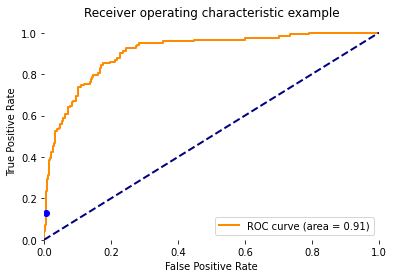

In [73]:
earlystop = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='auto', restore_best_weights=True) # we stop training after not improving after 50 epochs on the validation data
model.fit(x=xtrain, y=Yrestrain, batch_size=batch_size, epochs=epochs, verbose=1, 
          callbacks=[earlystop], validation_data=(xval,Yresval), shuffle=True) # train the neural network


pval = model.predict(xval) # Get the validation predictions

evaluate_performance(yval, pval) # evaluate the validation predictions

evaluate over test patients
('Created dataset[', 1000, ' x ', 100, '] with', 123.0, 'diseased')


Confusion matrix
[[862  15]
 [ 81  42]]


Area under the Curve (AUC) =  0.8950134883332869
Specificity =  0.9828962371721779
Sensitivity =  0.34146341463414637
F_1 score = 0.46666666666666673


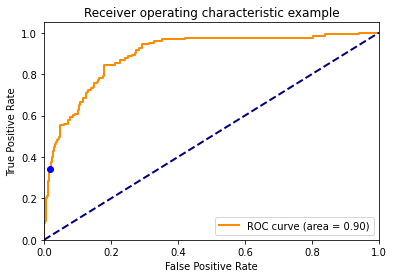

In [10]:
# print("evaluate over test patients")
# xtest, ytest, _ = get_simdata(num_features=inputsize, num_patients=test_size, random_seed=12+ jobid) # get the test set
# # ptest = model.predict(xtest) # predict with the trained neural network, optimized with the validation set
# evaluate_performance(ytest, ptest) # get the unbiased predictions

## Compare with logistic regression 



Confusion matrix
[[850  27]
 [ 83  40]]


Area under the Curve (AUC) =  0.6472082394712203
Specificity =  0.9692132269099202
Sensitivity =  0.3252032520325203
F_1 score = 0.42105263157894735


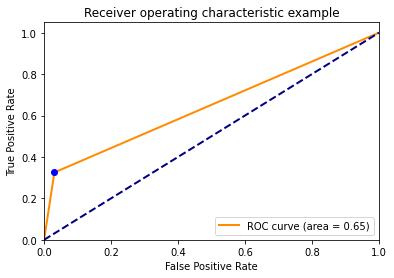

In [11]:
import sklearn
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs').fit(xtrain, ytrain)
ptest_lr = clf.predict(xtest)

evaluate_performance(ytest, ptest_lr)

### Inspect the betas of the logistic regression to see which SNPs are important for prediction

In [74]:
#@title Show the important weights for logistic regression

betas_lr = pd.DataFrame(clf.coef_[:].T, columns=["Betas logistic regression"])
betas_lr_s = betas_lr.sort_values("Betas logistic regression",ascending=False)
print("Causal SNPs are:", causal_snps)
betas_lr_s.head(12)




Causal SNPs are: [[0, 6, 12, 19], [9, 4, 21, 29]]


,Betas logistic regression
6,1.581362
9,1.555484
19,1.397774
21,0.351140
12,0.307138
33,0.149313
17,0.125541
99,0.123945
67,0.121551
43,0.101931


On this toy example the network performs thus substantially better than logistic regression. We will inspect interpretability next by plotting the weights


## Plot network

We plot the network below. The line-thickness between the nodes represent the strenght of the connections (magnitude of the weight)

In [88]:
# model.layers.name
for layer in model.layers:
    print(layer.name)

inputs_
reshape_3
gene_layer
flatten_3
gene_activation
inter_out
dense_3


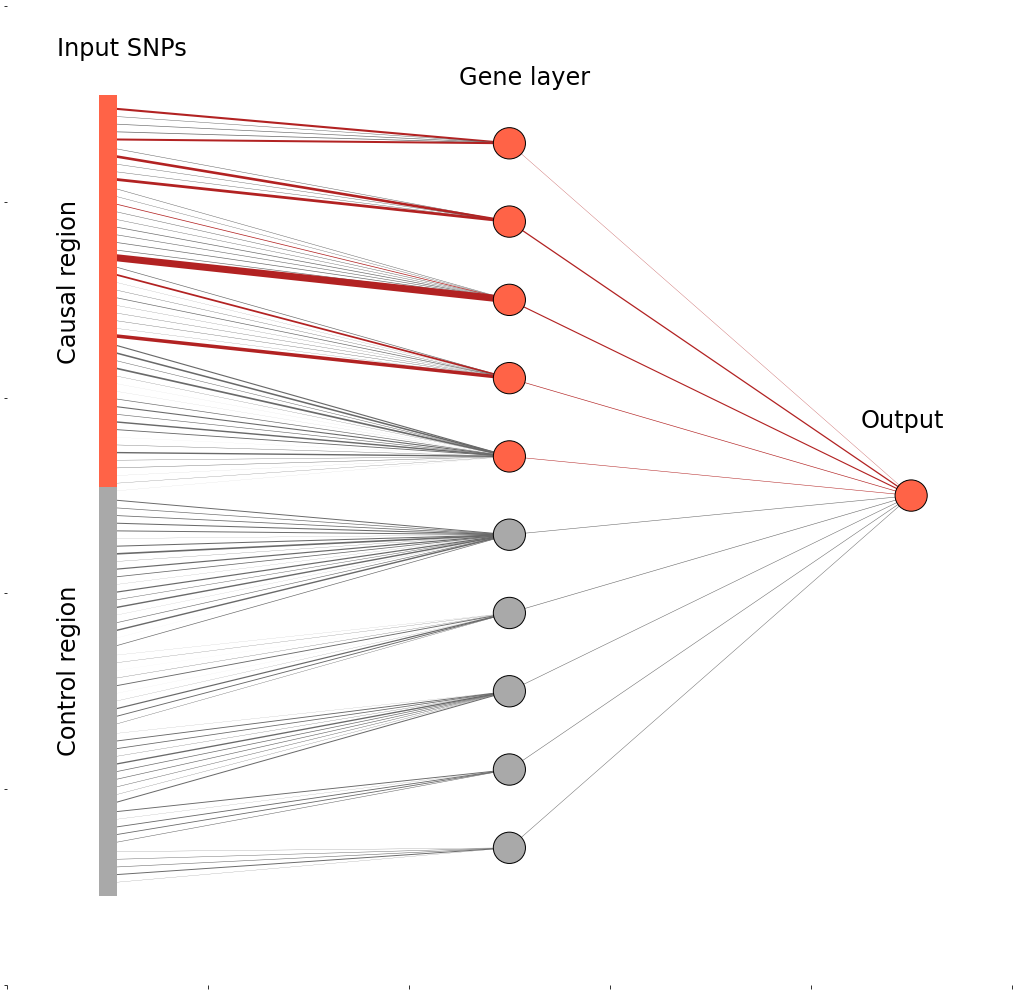

In [80]:
#@title Plot network 
from matplotlib import cm
import matplotlib.patches as mpatches

weight_locally = model.layers[2].get_weights()[0]
weights_dense = model.layers[6].get_weights()[0]

causal_snps = np.array(causal_snps)
colors = plt.cm.tab10(np.linspace(0,1,10))
fig = plt.figure(figsize=(18, 18))

n_layers = 3
gene_mask = genemask.todense()
layer_sizes = [genemask.shape[0], genemask.shape[1], 1]


ax = fig.gca()
top=0.9
bottom=0.1
left = 0.1
right = 0.9
                 
v_spacing = (top - bottom)/float(max(layer_sizes))
h_spacing = (right - left)/float(len(layer_sizes) - 1)


causal_red = "firebrick" #"#7dcfe2"
causal_circle_red = "tomato" #"#4b78b5"
gray1 = "darkgrey"
gray2 = "dimgray"

linewith_genes = (weights_dense * 5 + 0.5)
linewith_snps = (weight_locally* 5+0.5)
colormap_snps = np.zeros(inputsize, dtype=object)
colormap_snps[:] =gray2
colormap_snps[causal_snps] = causal_red
colormap_genes = np.zeros((gene_mask.shape[1]), dtype=object)
colormap_genes[:int(len(colormap_genes)/2)] = causal_red
colormap_genes[int(len(colormap_genes)/2):] = gray2
colormap_circle_genes = np.zeros((gene_mask.shape[1]), dtype=object)
colormap_circle_genes[:int(len(colormap_circle_genes)/2)] = causal_circle_red
colormap_circle_genes[int(len(colormap_circle_genes)/2):] = gray1



#SNPs
n=0    
layer_size = layer_sizes[0]
layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2

y_snps=[]
layer_size_a = gene_mask.shape[0]
layer_size_b = gene_mask.shape[1]
layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
for m in range(layer_size):
    y_snps.append(layer_top_a - m*v_spacing) 
        
line_vert_1 =plt.Line2D(xdata=[n*h_spacing + left, n*h_spacing + left],
                                  ydata=[top, ((top-bottom)/2)+bottom ],
                                  c=causal_circle_red, linewidth = "18")


line_vert_2 =plt.Line2D(xdata=[n*h_spacing + left, n*h_spacing + left],
                                  ydata=[((top-bottom)/2)+bottom, bottom],
                                  c=gray1 , linewidth = "18")



## Gene layer
layer_sizes2 = [genemask.shape[1], 1]
v_spacing = (top - bottom)/float(max(layer_sizes2))


n=1
layer_size = layer_sizes[1]
layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2

layer2xy = []
for m in range(layer_size):
    layer2xy.append( (n*h_spacing + left, layer_top - m*v_spacing))
    circle = plt.Circle(xy=layer2xy[m], radius=v_spacing/5,
                        color=colormap_circle_genes[m], ec='k', zorder=4)
    ax.add_artist(circle)

    
## Dense layer

n=2
layer_size = layer_sizes[2]
layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2


for m in range(layer_size):
    circle = plt.Circle(xy=(n*h_spacing + left, layer_top - m*v_spacing), radius=v_spacing/5,
                         color = causal_circle_red, ec='k', zorder=4)
    ax.add_artist(circle)   



# draw lines    
teller_snp_lines = 0
for column in range(gene_mask.shape[1]):
    rows = np.where(gene_mask[:,column]!=0)
    for row in rows[0]:
            line = plt.Line2D(xdata=[left,        layer2xy[column][0]],
                              ydata=[y_snps[row], layer2xy[column][1]],
                              c = colormap_snps[teller_snp_lines], linewidth = linewith_snps[teller_snp_lines])
            ax.add_artist(line)
            teller_snp_lines +=1
            
for column in range(gene_mask.shape[1]):
        line = plt.Line2D(xdata=[layer2xy[column][0],right],
                          ydata=[layer2xy[column][1], layer_top - m*v_spacing],
                          c = colormap_genes[column], linewidth = linewith_genes[column])
        ax.add_artist(line)



plt.annotate("Control region" ,xy=(left/2,0.24), size = 24, rotation = "90")
plt.annotate("Causal region", xy=(left/2,0.64), size=24, rotation = "90")
plt.annotate("Input SNPs", xy=(left-0.05,0.95), size=24, rotation = "0")
plt.annotate("Gene layer", xy=(layer2xy[0][0]-0.05,0.92), size=24)
plt.annotate("Output", xy=(right-0.05,0.57), size=24)
        
ax.add_artist(line_vert_1)
ax.add_artist(line_vert_2)
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False

plt.savefig("simulation_non_linear4.pdf")
plt.show()


The network assigns high weights to causal SNP pairs ([0, 4], [6, 9],[12, 19], [21, 29],[35, 45]) The network is thus fully interpretable because each node and connection represents a contribution of the SNP to the gene or the contribution of the gene on the output. The weights gives an indication on how strong this contribition is.

The network is interpretable because it is not fully connected, instead prior knowledge is used to create an interpretable neural network.


# Epistasis detection

In [81]:
import itertools
def GenNet_pairwise_interactions(w_input, w_later, gene_end):
  interaction_ranking = []
  list_of_combinations = []
  for neuron_number in range(len(gene_end)-1):
    neuron_combinations=list(itertools.combinations(np.arange(gene_end[neuron_number],gene_end[neuron_number+1]), 2 ))
  
    for candidate in neuron_combinations:
      strength = (np.minimum(w_input[candidate[0]], w_input[candidate[1]])*w_later[neuron_number]).sum()
      interaction_ranking.append(((candidate[0], candidate[1]), strength))
  
  interaction_ranking.sort(key=lambda x: x[1], reverse=True)
  return interaction_ranking


List of causal Snps

In [82]:
causal_snps

array([[ 0,  6, 12, 19],
       [ 9,  4, 21, 29]])

*interaction_ranking* contains the ranking of the found interactions. This is the main output to use to find epistasis pairs

In [83]:
w_later = np.abs(weights_dense)
w_input = np.abs(weight_locally)

interaction_ranking = GenNet_pairwise_interactions(w_input,w_later, gene_end)
interaction_ranking[:25]

[((6, 9), 0.06428247),
 ((0, 4), 0.0135863945),
 ((21, 29), 0.0065668495),
 ((12, 19), 0.005931266),
 ((12, 17), 0.004498149),
 ((17, 19), 0.004498149),
 ((12, 15), 0.004255485),
 ((15, 17), 0.004255485),
 ((15, 19), 0.004255485),
 ((11, 12), 0.0033060052),
 ((11, 15), 0.0033060052),
 ((11, 17), 0.0033060052),
 ((11, 19), 0.0033060052),
 ((11, 18), 0.0032437807),
 ((12, 18), 0.0032437807),
 ((15, 18), 0.0032437807),
 ((17, 18), 0.0032437807),
 ((18, 19), 0.0032437807),
 ((74, 78), 0.0031507968),
 ((6, 7), 0.0024198107),
 ((7, 9), 0.0024198107),
 ((11, 14), 0.0022873573),
 ((12, 14), 0.0022873573),
 ((14, 15), 0.0022873573),
 ((14, 17), 0.0022873573)]

 # Generate coactivation matrix

In [89]:
import itertools
layer_name = 'gene_activation'
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
gene_activation_train = intermediate_layer_model.predict(xtrain)

# layer_name = 'output_activation'
layer_name = 'dense_3'
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
output_activation_train = intermediate_layer_model.predict(xtrain)

In [91]:
total_activation = np.concatenate((gene_activation_train, output_activation_train) , axis =1 )

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


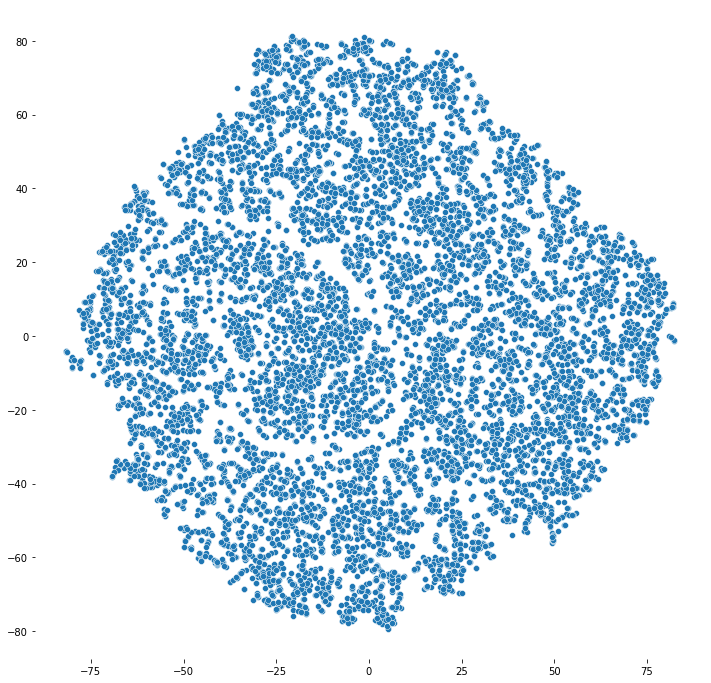

In [92]:
from sklearn.manifold import TSNE
import seaborn as sns
sns.color_palette("rocket")
TSNE_activation = TSNE(random_state=0, n_components=2  ).fit_transform(total_activation)
plt.figure(figsize = (12,12))
sns.scatterplot(TSNE_activation[:,0], TSNE_activation[:,1])

In [93]:
gene_activation_train.shape
ngenes = xtrain.shape[1]
ngenes

100

In [94]:
gene_activation_train.shape


(10000, 10)

In [112]:
results = pd.DataFrame(gene_activation_train, 
                       index=['pid_{}'.format(i) for i in range(nsubjects)]
                      , columns=['gene_{}'.format(i + 1) for i in range(ngenes)])
results

,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10
pid_0,0.686099,-0.900580,-0.760396,-0.938077,0.563753,-0.650015,-0.860234,-0.374086,-0.641533,0.534439
pid_1,0.646836,-0.765514,-0.998628,-0.984561,-0.389129,0.074691,-0.571733,-0.446640,-0.334486,0.596756
pid_2,0.626529,-0.981609,-0.983519,-0.591407,0.329895,0.027541,-0.907245,0.128183,-0.783523,0.494481
pid_3,0.653882,-0.957810,-0.976372,-0.572312,0.046166,-0.150144,-0.363924,-0.008646,-0.397562,0.493984
pid_4,0.631348,-0.956652,-0.998566,-0.981575,0.538670,-0.539187,-0.813586,-0.233894,-0.647273,0.465200
...,...,...,...,...,...,...,...,...,...,...
pid_9995,0.614191,-0.981017,-0.979922,-0.928985,0.183407,-0.289240,-0.730069,0.072376,-0.210245,0.567535
pid_9996,0.416712,-0.751756,-0.775857,-0.934299,0.418541,-0.413955,-0.352574,0.037248,-0.461911,0.465200
pid_9997,0.614191,-0.956652,-0.998665,-0.921198,0.024880,-0.148428,-0.751616,0.116421,-0.135307,0.499126
pid_9998,0.765532,-0.982215,-0.981097,-0.525201,0.438603,-0.734791,-0.571610,-0.032864,-0.456484,0.625103


In [113]:
nsubjects = xtrain.shape[0]
ngenes = 10

results = pd.DataFrame(gene_activation_train, 
                       index=['pid_{}'.format(i) for i in range(nsubjects)]
                      , columns=['gene_{}'.format(i + 1) for i in range(ngenes)])

# if using relu, you can change the threshold here
thres = 0.75
results = (results.abs()>=thres).astype(int)

combs = list(itertools.combinations(results.columns, 2))
coactivation = pd.DataFrame(index=['gene_{}'.format(i + 1) for i in range(ngenes)],
                            columns=['gene_{}'.format(i + 1) for i in range(ngenes)])
for comb in combs:
    coactivation.loc[comb[0], comb[1]] = pd.crosstab(results[comb[0]], results[comb[1]]).iloc[-1, -1]
    
for gene in ['gene_{}'.format(i) for i in range(1, 11)]:
    coactivation.loc[gene, gene] = results[gene].sum()

In [114]:
pd.crosstab(coactivation[comb[0]], coactivation[comb[1]])

gene_10,1,174,372,582,3469,5230,5923,9757,9911
gene_9,,,,,,,,,
0,1,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0
27,0,0,1,0,0,0,0,0,0
194,0,0,0,0,1,0,0,0,0
303,0,0,0,0,0,1,0,0,0
339,0,0,0,0,0,0,1,0,0
564,0,0,0,0,0,0,0,1,0
578,0,0,0,0,0,0,0,0,1
582,0,0,0,1,0,0,0,0,0


In [115]:
coactivation

,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10
gene_1,3469,3439,3380,1814,126,53,2060,0,194,3469
gene_2,NaN,9911,9670,5185,368,174,5875,1,578,9911
gene_3,NaN,NaN,9757,5106,364,169,5782,1,564,9757
gene_4,NaN,NaN,NaN,5230,180,88,3089,0,303,5230
gene_5,NaN,NaN,NaN,NaN,372,7,224,0,27,372
gene_6,NaN,NaN,NaN,NaN,NaN,174,91,0,5,174
gene_7,NaN,NaN,NaN,NaN,NaN,NaN,5923,0,339,5923
gene_8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1
gene_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,582,582
gene_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


combs

In [116]:
results

,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10
pid_0,0,1,1,1,0,0,1,0,0,0
pid_1,0,1,1,1,0,0,0,0,0,0
pid_2,0,1,1,0,0,0,1,0,1,0
pid_3,0,1,1,0,0,0,0,0,0,0
pid_4,0,1,1,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
pid_9995,0,1,1,1,0,0,0,0,0,0
pid_9996,0,1,1,1,0,0,0,0,0,0
pid_9997,0,1,1,1,0,0,1,0,0,0
pid_9998,1,1,1,0,0,0,0,0,0,0


## significant test

I want to identify a culmulative binomial distribution p value for each item, to understand the probability of observing an equal or higher number of item occurrences.


##Coactivation

The Ho is that the co-activation is smaller or equal to the one in the hyphotesis of no coactivation --> one side alternative hyphotesis. 

Here it is implemented with the H0 of no coactivation



In [117]:
from scipy.stats.distributions import binom
for comb in combs:
    conTable = pd.crosstab(results[comb[0]], results[comb[1]])
    if conTable.shape == (2, 2) and 0 not in conTable.values:
        b = conTable.loc[1].loc[1]
        a = sum(conTable.loc[1])
        c = sum(conTable.loc[:,1])
        n = conTable.values.sum()
        p = binom.cdf(b, n, a*c/(n*n))
        print('p-value for {} and {} is: {:.3f}'.format(comb[0], comb[1], p))

p-value for gene_1 and gene_2 is: 0.512
p-value for gene_1 and gene_3 is: 0.465
p-value for gene_1 and gene_4 is: 0.503
p-value for gene_1 and gene_5 is: 0.416
p-value for gene_1 and gene_6 is: 0.189
p-value for gene_1 and gene_7 is: 0.558
p-value for gene_1 and gene_9 is: 0.302
p-value for gene_2 and gene_3 is: 0.504
p-value for gene_2 and gene_4 is: 0.516
p-value for gene_2 and gene_5 is: 0.499
p-value for gene_2 and gene_7 is: 0.542
p-value for gene_2 and gene_9 is: 0.531
p-value for gene_3 and gene_4 is: 0.529
p-value for gene_3 and gene_5 is: 0.536
p-value for gene_3 and gene_6 is: 0.497
p-value for gene_3 and gene_7 is: 0.527
p-value for gene_3 and gene_9 is: 0.445
p-value for gene_4 and gene_5 is: 0.154
p-value for gene_4 and gene_6 is: 0.402
p-value for gene_4 and gene_7 is: 0.430
p-value for gene_4 and gene_9 is: 0.483
p-value for gene_5 and gene_6 is: 0.677
p-value for gene_5 and gene_7 is: 0.615
p-value for gene_5 and gene_9 is: 0.893
p-value for gene_6 and gene_7 is: 0.125


In [118]:
conTable

gene_10,0
gene_9,
0,9418
1,582


##CONCORDANCE

The Ho is that the co-activation is smaller or equal to the one in the hyphotesis of no coactivation --> one side alternative hyphotesis. 

Here it is implemented with the H0 of CONCORDANCE (diagonal vs off-diagonal)

UPDATE: the *concordance* is not anymore considered a viable option: we would implement, for the indipendence of the two genes, two different tests: chi_square and G_square



In [119]:
from scipy.stats.distributions import binom
for comb in combs:
    conTable = pd.crosstab(results[comb[0]], results[comb[1]])
    if conTable.shape == (2, 2) and 0 not in conTable.values:
        b = conTable.loc[1].loc[1]
        a = sum(conTable.loc[1])
        c = sum(conTable.loc[:,1])
        n = conTable.values.sum()
        theta = a*c/(n*n)+( ((n-a)/n)* ((n-c)/n) )
        obs = b + n - a - c + b
        p = binom.cdf(obs, n, theta )
        print('p-value for {} and {} is: {:.3f}'.format(comb[0], comb[1], p))

p-value for gene_1 and gene_2 is: 0.519
p-value for gene_1 and gene_3 is: 0.427
p-value for gene_1 and gene_4 is: 0.499
p-value for gene_1 and gene_5 is: 0.453
p-value for gene_1 and gene_6 is: 0.383
p-value for gene_1 and gene_7 is: 0.588
p-value for gene_1 and gene_9 is: 0.375
p-value for gene_2 and gene_3 is: 0.500
p-value for gene_2 and gene_4 is: 0.529
p-value for gene_2 and gene_5 is: 0.486
p-value for gene_2 and gene_7 is: 0.580
p-value for gene_2 and gene_9 is: 0.548
p-value for gene_3 and gene_4 is: 0.553
p-value for gene_3 and gene_5 is: 0.546
p-value for gene_3 and gene_6 is: 0.482
p-value for gene_3 and gene_7 is: 0.551
p-value for gene_3 and gene_9 is: 0.397
p-value for gene_4 and gene_5 is: 0.283
p-value for gene_4 and gene_6 is: 0.456
p-value for gene_4 and gene_7 is: 0.367
p-value for gene_4 and gene_9 is: 0.482
p-value for gene_5 and gene_6 is: 0.525
p-value for gene_5 and gene_7 is: 0.563
p-value for gene_5 and gene_9 is: 0.650
p-value for gene_6 and gene_7 is: 0.316


##Indipendence test

Indipendence test: chi_square test and g-test from [Scipy **library**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html) and Fisher exact test

#Chi-square score approximate test

In [120]:
from scipy.stats import chi2_contingency
for comb in combs:
    conTable = pd.crosstab(results[comb[0]], results[comb[1]])
    if conTable.shape == (2, 2) and 0 not in conTable.values:
        _, p, _, _ = chi2_contingency(conTable)
        print('p-value for {} and {} is: {:.3f}'.format(comb[0], comb[1], p))

p-value for gene_1 and gene_2 is: 0.933
p-value for gene_1 and gene_3 is: 0.566
p-value for gene_1 and gene_4 is: 0.993
p-value for gene_1 and gene_5 is: 0.777
p-value for gene_1 and gene_6 is: 0.270
p-value for gene_1 and gene_7 is: 0.837
p-value for gene_1 and gene_9 is: 0.507
p-value for gene_2 and gene_3 is: 0.816
p-value for gene_2 and gene_4 is: 0.823
p-value for gene_2 and gene_5 is: 0.915
p-value for gene_2 and gene_7 is: 0.361
p-value for gene_2 and gene_9 is: 0.757
p-value for gene_3 and gene_4 is: 0.736
p-value for gene_3 and gene_5 is: 0.853
p-value for gene_3 and gene_6 is: 0.893
p-value for gene_3 and gene_7 is: 0.748
p-value for gene_3 and gene_9 is: 0.352
p-value for gene_4 and gene_5 is: 0.137
p-value for gene_4 and gene_6 is: 0.702
p-value for gene_4 and gene_7 is: 0.737
p-value for gene_4 and gene_9 is: 0.940
p-value for gene_5 and gene_6 is: 0.991
p-value for gene_5 and gene_7 is: 0.734
p-value for gene_5 and gene_9 is: 0.274
p-value for gene_6 and gene_7 is: 0.072


#G-test likelihood approximate test

In [121]:
from scipy.stats import chi2_contingency
for comb in combs:
    conTable = pd.crosstab(results[comb[0]], results[comb[1]])
    if conTable.shape == (2, 2) and 0 not in conTable.values:
        _, p, _, _ = chi2_contingency(conTable, lambda_="log-likelihood")
        print('p-value for {} and {} is: {:.3f}'.format(comb[0], comb[1], p))

p-value for gene_1 and gene_2 is: 0.933
p-value for gene_1 and gene_3 is: 0.568
p-value for gene_1 and gene_4 is: 0.993
p-value for gene_1 and gene_5 is: 0.777
p-value for gene_1 and gene_6 is: 0.266
p-value for gene_1 and gene_7 is: 0.837
p-value for gene_1 and gene_9 is: 0.506
p-value for gene_2 and gene_3 is: 0.820
p-value for gene_2 and gene_4 is: 0.823
p-value for gene_2 and gene_5 is: 0.916
p-value for gene_2 and gene_7 is: 0.364
p-value for gene_2 and gene_9 is: 0.752
p-value for gene_3 and gene_4 is: 0.736
p-value for gene_3 and gene_5 is: 0.852
p-value for gene_3 and gene_6 is: 0.894
p-value for gene_3 and gene_7 is: 0.749
p-value for gene_3 and gene_9 is: 0.368
p-value for gene_4 and gene_5 is: 0.137
p-value for gene_4 and gene_6 is: 0.702
p-value for gene_4 and gene_7 is: 0.737
p-value for gene_4 and gene_9 is: 0.940
p-value for gene_5 and gene_6 is: 0.991
p-value for gene_5 and gene_7 is: 0.733
p-value for gene_5 and gene_9 is: 0.289
p-value for gene_6 and gene_7 is: 0.074


# Fisher exact test

In [105]:
from scipy.stats import fisher_exact
for comb in combs:
    conTable = pd.crosstab(results[comb[0]], results[comb[1]])
    if conTable.shape == (2, 2) and 0 not in conTable.values:
        _, p = fisher_exact(conTable, alternative='two-sided')
        print('p-value for {} and {} is: {:.3f}'.format(comb[0], comb[1], p))

p-value for gene_1 and gene_4 is: 0.849
p-value for gene_1 and gene_5 is: 0.049
p-value for gene_1 and gene_6 is: 0.390
p-value for gene_1 and gene_7 is: 0.882
p-value for gene_1 and gene_8 is: 0.933
p-value for gene_1 and gene_9 is: 0.660
p-value for gene_1 and gene_10 is: 0.496
p-value for gene_4 and gene_5 is: 0.882
p-value for gene_4 and gene_6 is: 0.472
p-value for gene_4 and gene_7 is: 0.888
p-value for gene_4 and gene_8 is: 0.810
p-value for gene_4 and gene_9 is: 0.448
p-value for gene_4 and gene_10 is: 0.663
p-value for gene_5 and gene_6 is: 0.404
p-value for gene_5 and gene_7 is: 0.212
p-value for gene_5 and gene_8 is: 0.838
p-value for gene_5 and gene_9 is: 0.445
p-value for gene_5 and gene_10 is: 0.523
p-value for gene_6 and gene_7 is: 0.826
p-value for gene_6 and gene_8 is: 0.262
p-value for gene_6 and gene_9 is: 0.027
p-value for gene_6 and gene_10 is: 0.855
p-value for gene_7 and gene_8 is: 0.755
p-value for gene_7 and gene_9 is: 0.732
p-value for gene_7 and gene_10 is: 1